[View in Colaboratory](https://colab.research.google.com/github/muik/notebooks/blob/master/daangn/profile_image_detector_using_tf_hub.ipynb)

# 당근이 이미지 탐지기
당근마켓의 당근이 캐릭터 이미지 탐지기 구현/배포 코드입니다.

## Tensorflow Model

스텝별 코드의 설명은 다음의 블로그 글을 참고해주세요.

https://medium.com/p/abd967638c8e/edit

### Step 1~4) Build Tensorflow graph


In [0]:
!pip -q install tensorflow-hub

import tensorflow as tf
import tensorflow_hub as hub

CHANNELS = 3 # number of image channels (RGB)

def build_graph(hub_module_url, target_image_path):
  # Step 1) Prepare pre-trained model for extracting image features.
  module = hub.Module(hub_module_url)
  height, width = hub.get_expected_image_size(module)

  # Copied a method of https://github.com/GoogleCloudPlatform/cloudml-samples/blob/bf0680726/flowers/trainer/model.py#L181
  # and fixed for all type images (not only jpeg)
  def decode_and_resize(image_str_tensor):
    """Decodes jpeg string, resizes it and returns a uint8 tensor."""
    image = tf.image.decode_image(image_str_tensor, channels=CHANNELS)
    # Note resize expects a batch_size, but tf_map supresses that index,
    # thus we have to expand then squeeze.  Resize returns float32 in the
    # range [0, uint8_max]
    image = tf.expand_dims(image, 0)
    image = tf.image.resize_bilinear(
        image, [height, width], align_corners=False)
    image = tf.squeeze(image, squeeze_dims=[0])
    image = tf.cast(image, dtype=tf.uint8)
    return image

  def to_img_feature(images):
    """Extract the feature of image vectors"""
    outputs = module(dict(images=images), signature="image_feature_vector", as_dict=True)
    return outputs['default']

  # Step 2) Extract image features of the target image.
  target_image_bytes = tf.gfile.GFile(target_image_path, 'rb').read()
  target_image = tf.constant(target_image_bytes, dtype=tf.string)
  target_image = decode_and_resize(target_image)
  target_image = tf.image.convert_image_dtype(target_image, dtype=tf.float32)
  target_image = tf.expand_dims(target_image, 0)
  target_image = to_img_feature(target_image)

  # Step 3) Extract image features of input images.
  input_byte = tf.placeholder(tf.string, shape=[None])
  input_image = tf.map_fn(decode_and_resize, input_byte, back_prop=False, dtype=tf.uint8)
  input_image = tf.image.convert_image_dtype(input_image, dtype=tf.float32)
  input_image = to_img_feature(input_image)

  # Step 4) Compare cosine_similarities of the target image and the input images.
  dot = tf.tensordot(target_image, tf.transpose(input_image), 1)
  similarity = dot / (tf.norm(target_image, axis=1) * tf.norm(input_image, axis=1))
  similarity = tf.reshape(similarity, [-1])
  
  return input_byte, similarity

### Step 5) Run

#### Download target and input images

In [0]:
target_image_url = "https://d2192bm55jmxp1.cloudfront.net/resize/s/profile/201712/B4CFF0B690BB910AF5CB97A2122E9AEC427DAD810E4E0382B13643C9A8D22A55.jpg" #@param {type:"string"}
input_image1_url = "https://d2192bm55jmxp1.cloudfront.net/resize/s/profile/201706/5b193314eff5f5b90faf9e5600d2c95c0c86c4c154414ea8a69bc26942a37613.jpg" #@param {type:"string"}
input_image2_url = "https://d2192bm55jmxp1.cloudfront.net/resize/s/profile/201803/b15cd493adfd367b6663786ca21c4ecdeba67c859ac628849ebd4c3f7990f92b.jpg" #@param {type:"string"}
input_image3_url = "https://d2192bm55jmxp1.cloudfront.net/resize/s/profile/201804/8d4b782228f43fb859076c41ae69a1920aec1b20154ea059a8e87142b66a9841.jpg" #@param {type:"string"}
input_image4_url = "https://d2192bm55jmxp1.cloudfront.net/resize/s/profile/201803/4D2C44F3BB10CB84D0D6894321ED9C8761BB364786550762DC13B125B4C34361.jpg" #@param {type:"string"}

input_image_urls = [input_image1_url, input_image2_url, input_image3_url, input_image4_url]

target_img_path = 'target_img.jpg'
input_img_paths = []

!wget -q {target_image_url} -O {target_img_path}

for i, url in enumerate(input_image_urls):
  if len(url) > 0:
    path = "input_img%d.jpg" % i
    !wget -q {url} -O {path}
    input_img_paths.append(path)

#### Compare  target and input images

**hub_module_url** 필드값은 이미지 모듈의 url 입니다.

이미지 사이즈와 성능/속도에 따라 다양한 모듈이 있습니다. TF Hub의 [Image Modules](https://www.tensorflow.org/hub/modules/image) 를 참고해주세요.



5 images inference time: 1.67 s
# Target image


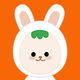

- similarity: 1.00
# Input images


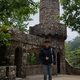

- similarity: 0.26


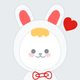

- similarity: 0.71


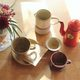

- similarity: 0.36


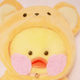

- similarity: 0.66


In [0]:
import time
import tensorflow as tf
from IPython.display import Image, display
tf.logging.set_verbosity(tf.logging.ERROR)

# Load bytes of image files
image_bytes = [tf.gfile.GFile(name, 'rb').read()
               for name in [target_img_path] + input_img_paths]

hub_module_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/1" #@param {type:"string"}

with tf.Graph().as_default():
  input_byte, similarity_op = build_graph(hub_module_url, target_img_path)
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    t0 = time.time() # for time check
    
    # Inference similarities
    similarities = sess.run(similarity_op, feed_dict={input_byte: image_bytes})
    
    print("%d images inference time: %.2f s" % (len(similarities), time.time() - t0))

# Display results
print("# Target image")
display(Image(target_img_path))
print("- similarity: %.2f" % similarities[0])

print("# Input images")
for similarity, input_img_path in zip(similarities[1:], input_img_paths):
  display(Image(input_img_path))
  print("- similarity: %.2f" % similarity)

## Deploy on Cloud ML Engine
위의 텐서플로우 모델을 클라우드 머신러닝 엔진에 배포합니다.

### Export the tensorflow model file
모델을 배포하기 위한 텐서플로우 모델을 파일로 저장합니다.


In [0]:
!rm -rf model*
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils as saved_model_utils

# Copied a method of https://github.com/GoogleCloudPlatform/cloudml-samples/blob/bf0680726/flowers/trainer/model.py#L52
def build_signature(inputs, outputs):
  """Build the signature.
  Not using predic_signature_def in saved_model because it is replacing the
  tensor name, b/35900497.
  Args:
    inputs: a dictionary of tensor name to tensor
    outputs: a dictionary of tensor name to tensor
  Returns:
    The signature, a SignatureDef proto.
  """
  signature_inputs = {key: saved_model_utils.build_tensor_info(tensor)
                      for key, tensor in inputs.items()}
  signature_outputs = {key: saved_model_utils.build_tensor_info(tensor)
                       for key, tensor in outputs.items()}

  signature_def = signature_def_utils.build_signature_def(
      signature_inputs, signature_outputs,
      signature_constants.PREDICT_METHOD_NAME)

  return signature_def

with tf.Graph().as_default():
  input_byte, similarity_op = build_graph(hub_module_url, target_img_path)
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
  
    # export
    output_dir = "./model"

    keys_placeholder = tf.placeholder(tf.string, shape=[None])
    inputs = {
      'key': keys_placeholder,
      'image_bytes': input_byte
    }
    keys = tf.identity(keys_placeholder)
    outputs = {
        'key': keys,
        'similarity': similarity_op
    }

    signature_def = build_signature(inputs=inputs, outputs=outputs)
    signature_def_map = {
        signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature_def
    }
    builder = saved_model_builder.SavedModelBuilder(output_dir)
    builder.add_meta_graph_and_variables(
        sess,
        tags=[tag_constants.SERVING],
        signature_def_map=signature_def_map)
    builder.save()

### Google Cloud Authentication
Cloud ML Engine에 모델을 등록하기 위해 구글 클라우드 인증을 합니다.

In [0]:
from google.colab import auth
auth.authenticate_user()

### Create model on Cloud ML Engine

저장된 모델파일을 클라우드 머신러닝 엔진에 모델로 등록합니다.

아래 입력 폼의 아래 필드는 **나의 계정에 맞게 입력**해야 합니다.

* project_id : 나의 Google Cloud Project ID
* staging_bucket : 나의 Google Cloud Storage Bucket 주소

자세한 내용은 [공식 안내 페이지](https://cloud.google.com/ml-engine/docs/tensorflow/getting-started-training-prediction#set-up-your-gcp-project)를 참고해주세요.



In [0]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'towneers' #@param {type:"string"}
!gcloud config set project {project_id}

model_name = 'profile_image_detector' #@param {type:"string"}
!gcloud ml-engine models create {model_name}

version = 'base' #@param {type:"string"}
staging_bucket = 'gs://towneers-ml'  #@param {type:"string"}
!gcloud ml-engine versions create {version} --model {model_name} \
  --runtime-version 1.7 --origin ./model --staging-bucket {staging_bucket}

Updated property [core/project].
Created ml engine model [projects/towneers/models/profile_image_detector].
Creating version (this might take a few minutes)......done.


## Request to Cloud ML Engine
배포된 클라우드 머신러닝 엔진 모델에 이미지 비교 요청을 합니다.

### Make a instance file to request
클라우드 머신러닝 모델의 input 형식에 맞는 요청 파일을 생성합니다.

In [8]:
import base64
try:
    from StringIO import StringIO
except ImportError:
    from io import BytesIO as StringIO
import json
import sys

from PIL import Image

desired_width = 96
desired_height = 96

# Copied a method of https://github.com/GoogleCloudPlatform/cloudml-samples/blob/bf0680726/flowers/images_to_json.py#L62
def make_request_json(input_images, output_json, do_resize):
  """Produces a JSON request suitable to send to CloudML Prediction API.
  Args:
    input_images: List of file handles corresponding to images to be encoded.
    output_json: File handle of the output json where request will be written.
    do_resize: Boolean specifying if script should resize images.
  """

  with open(output_json, 'w') as ff:
    for image_handle in input_images:
      image = Image.open(image_handle)
      resized_handle = StringIO()
      is_too_big = ((image.size[0] * image.size[1]) >
                    (desired_width * desired_height))
      if do_resize and is_too_big:
        image = image.resize((desired_width, desired_height), Image.BILINEAR)
        image.save(resized_handle, format='JPEG')
        contents = resized_handle.getvalue()
      else:
        contents = tf.gfile.GFile(image_handle, 'rb').read()
        
      encoded_contents = base64.b64encode(contents)

      # key can be any UTF-8 string, since it goes in a HTTP request.
      row = json.dumps({'key': image_handle,
                        'image_bytes': {'b64': encoded_contents.decode("utf-8")}})

      ff.write(row)
      ff.write('\n')

image_paths = [target_img_path] + input_img_paths

make_request_json(image_paths, 'instances.json', False)

!head -n 1 instances.json

{"key": "target_img.jpg", "image_bytes": {"b64": "/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAYEBAUEBAYFBQUGBgYHCQ4JCQgICRINDQoOFRIWFhUSFBQXGiEcFxgfGRQUHScdHyIjJSUlFhwpLCgkKyEkJST/2wBDAQYGBgkICREJCREkGBQYJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCT/wAARCABQAFADAREAAhEBAxEB/8QAHAAAAgIDAQEAAAAAAAAAAAAAAAcEBgEDBQII/8QANxAAAgEDAQcCAwQKAwAAAAAAAQIDAAQFEQYHEiExQVFhcRNCgRQikaEWIzIzUnKSscHRQ1Pw/8QAGwEAAQUBAQAAAAAAAAAAAAAAAAIDBQYHBAH/xAAxEQABAwMBBgQFBQEBAAAAAAABAAIDBBExBQYSIUFhwROBkaEUIkJRsSNy0eHwcfH/2gAMAwEAAhEDEQA/AJNY+trRQhXXBbq8xmLRbqeWKxjkHEiyAl2HkgdKsVJs3PMzfkO7fzP9Ks1u1FPA8xxtL7ZI4D+1xNptkslstcLHeorRSfu5o+aP6eh9KjtQ0uaicBJxBwRj/wBUlpurQV7SY+BGQc/2FxajlKIoQrJsrsLk9qg0sJS3tFPCZ5AdCfCjvUvpujTVo3x8rfueyhdU1yChO4RvP+w7nkpm027PKbPWjXkcsd7bINZGjUqyDyR49q6K/Z+amYZGHeaM8iPJc2nbSQVUgieNxxxzB81T6gFY0UIRQhdTZa2ivNo8ZbzAGOS5QMD3Guun5V3aZG2Srja7Fwo/VZHR0cr2ZDSn1lsqccESNFaR+f3ugFaXNNuYyssgg8TOFAyVpb7Z4C5sZkCS6cu/A/ysP/ea56iFlbA6J3P2PIrpp5n0FQ2ZnL3HMJBzQyW80kMq8MkbFGXwQdDWYPY5jix2RwWrxvbI0P

### Online prediction
요청 파일을 사용하여 실시간으로 비교 요청하고, 결과를 출력값으로 받아 확인합니다.

당근마켓에서는 사용자가 프로필 이미지를 변경할 때 비동기 작업으로 아래와 같이 요청하여 유사도를 측정합니다.

In [0]:
%%time
!gcloud ml-engine predict --model {model_name}  \
                   --version {version} \
                   --json-instances instances.json

KEY             SIMILARITY
target_img.jpg  1.0
input_img0.jpg  0.264985
input_img1.jpg  0.707859
input_img2.jpg  0.364175
input_img3.jpg  0.664559
CPU times: user 763 ms, sys: 266 ms, total: 1.03 s
Wall time: 42 s


### Batch prediction
비교할 이미지가 많을 경우 요청파일을 클라우드 스토리지에 업로드하고, 비동기 요청 배치작업을 실행합니다. 그리고 결과 데이터는 클라우드 스토리지에 저장됩니다.

아래의 필드값은 자신의 계정값으로 설정해야 합니다.

* input_gs_storage_path : 요청파일의 클라우드 스토리지 경로
* output_gs_storage_path : 결과 데이터가 저장될 클라우드 스토리지 경로

당근마켓에서는 기존의 사용자의 모든 이미지를 요청 파일로 변환하여 배치 작업으로 결과를 얻는데 사용했습니다.

In [0]:
input_gs_storage_path = 'gs://towneers-ml/profile_img_detector/instances.json' #@param {type:"string"}
output_gs_storage_path = 'gs://towneers-ml/profile_img_detector/results' #@param {type:"string"}

# Upload the instances.json file to Cloud Storage
!gsutil cp instances.json {input_gs_storage_path}

# Request a batch prediction job to Cloud ML Engine
!gcloud ml-engine jobs submit prediction profile_image_detect \
    --model {model_name} \
    --input-paths {input_gs_storage_path} \
    --output-path {output_gs_storage_path} \
    --data-format TEXT \
    --region us-central1

Copying file://instances.json [Content-Type=application/json]...
/ [1 files][ 15.1 KiB/ 15.1 KiB]                                                
Operation completed over 1 objects/15.1 KiB.                                     
Job [profile_image_detect] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe profile_image_detect

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs profile_image_detect
jobId: profile_image_detect
state: QUEUED


In [0]:
!gcloud ml-engine jobs describe profile_image_detect

createTime: '2018-06-18T05:42:15Z'
endTime: '2018-06-18T05:49:58Z'
jobId: profile_image_detect
predictionInput:
  dataFormat: JSON
  inputPaths:
  - gs://towneers-ml/profile_img_detector/instances.json
  modelName: projects/towneers/models/profile_image_detector
  outputPath: gs://towneers-ml/profile_img_detector/results
  region: us-central1
  runtimeVersion: '1.7'
predictionOutput:
  nodeHours: 0.13
  outputPath: gs://towneers-ml/profile_img_detector/results
  predictionCount: '5'
startTime: '2018-06-18T05:42:16Z'
state: SUCCEEDED

View job in the Cloud Console at:
https://console.cloud.google.com/ml/jobs/profile_image_detect?project=towneers

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fprofile_image_detect&project=towneers


In [0]:
!gsutil -m -q cp -r {output_gs_storage_path} ./
!ls -lh results

total 4.0K
-rw-r--r-- 1 root root   0 Jun 18 05:58 prediction.errors_stats-00000-of-00001
-rw-r--r-- 1 root root 300 Jun 18 05:58 prediction.results-00000-of-00001


In [0]:
!cat results/prediction.results-00000-of-00001

{"key": "target_img.jpg", "similarity": 0.9999999403953552}
{"key": "input_img0.jpg", "similarity": 0.2649848461151123}
{"key": "input_img1.jpg", "similarity": 0.7078585624694824}
{"key": "input_img2.jpg", "similarity": 0.3641752302646637}
{"key": "input_img3.jpg", "similarity": 0.6645594239234924}
